In [0]:

import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch.nn as nn
import torch

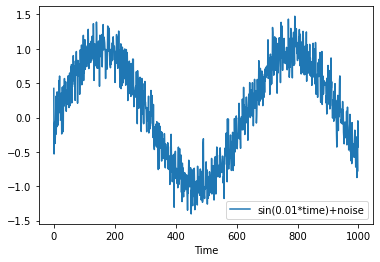

In [290]:
import torch

T = 1000
time = torch.arange(0.0, T)
X = torch.sin(0.01 * time) + 0.2 * torch.randn(T)
plt.plot(time.numpy(), X.numpy(), label="sin(0.01*time)+noise");
plt.legend();
plt.xlabel("Time");
plt.show()

In [0]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

# Hyperparameter
batch_size, train_number = 16, 600

# timestamp
tau = 4
features = torch.zeros((T-tau, tau)) # AR Model needs tau inputs: shape is (996, 4)

for i in range(tau):
    features[:, i] = X[i:(T-tau + i)]
labels = X[tau:] # shape is (996, )

# Prepare DataLoader
train_data = TensorDataset(features[:train_number, :], labels[:train_number])
test_data = TensorDataset(features[train_number:, :], labels[train_number:])

In [0]:
Z=[]
for i in range(0,1000):
  x=np.sin(0.01 * i) + 0.2 * np.random.randn(1)
  # print(x.shape)
  Z.append( x)

X_train = []
y_train = []

for i in range(100, 600):
    X_train.append(Z[i-100:i])
    y_train.append(Z[i])
    # print(i)
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshaping
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])

X_test = []
y_test = []

for i in range(600, 1000):
    X_test.append(Z[i-100:i])
    y_test.append(Z[i])
    # print(i)
X_test, y_test = np.array(X_test), np.array(y_test)

# Reshaping
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [273]:
y_train.shape

(996, 1)

In [46]:
X.shape

torch.Size([1000])

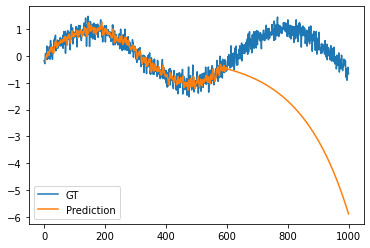

In [14]:
predictions = torch.zeros_like(estimates)
predictions[:(train_number - tau)] = estimates[:(train_number - tau)]

for i in range((train_number - tau), (T - tau)):
    predictions[i] = net(
        predictions[(i - tau):i].reshape(1, -1)
    ).reshape(1)

plt.plot(time.numpy(), X.numpy(), label='GT');
plt.plot(time[tau:].numpy(), predictions.detach().numpy(), label='Prediction');
plt.legend();

In [0]:
class RNN(nn.Module):
    def __init__(self, i_size, h_size, n_layers, o_size):
        super(RNN, self).__init__()

        self.rnn = nn.RNN(
            input_size=i_size,
            hidden_size=h_size,
            num_layers=n_layers
        )
        self.out = nn.Linear(h_size, o_size)

    def forward(self, x, h_state):
        r_out, hidden_state = self.rnn(x, h_state)
        
        hidden_size = hidden_state[-1].size(-1)
        r_out = r_out.view(-1, hidden_size)
        outs = self.out(r_out)

        return outs, hidden_state

In [0]:
# Hyperparameters
n_hidden = 50
lr = 0.001
epochs = 200

model = RNN(100, n_hidden, 2, 1)
# torch.autograd.set_detect_anomaly(True)
optimiser = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

In [331]:
print(model)
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

RNN(
  (rnn): RNN(100, 50, num_layers=2)
  (out): Linear(in_features=50, out_features=1, bias=True)
)


In [332]:
hidden_state = None
inputs = Variable(torch.from_numpy(X_train).float())
labels = Variable(torch.from_numpy(y_train).float())

for epoch in range(100):
  output=None
  hidden_state=None


  output, hidden_state = model(inputs, hidden_state) 
  loss=0

  loss = criterion(output.view(-1), labels)
  optimiser.zero_grad()
  loss.backward(retain_graph=True)                     # back propagation
  optimiser.step()                                     # update the parameters
    
  print('epoch {}, loss {}'.format(epoch,loss.item()))

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([500, 1])) that is different to the input size (torch.Size([500])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch 0, loss 0.6569156646728516
epoch 1, loss 0.858315110206604
epoch 2, loss 0.6769232749938965
epoch 3, loss 0.7119054794311523
epoch 4, loss 0.785919725894928
epoch 5, loss 0.7144386172294617
epoch 6, loss 0.6663175821304321
epoch 7, loss 0.6465240716934204
epoch 8, loss 0.7165160179138184
epoch 9, loss 0.6963301301002502
epoch 10, loss 0.6783444881439209
epoch 11, loss 0.6538289785385132
epoch 12, loss 0.642650306224823
epoch 13, loss 0.654653012752533
epoch 14, loss 0.6689847707748413
epoch 15, loss 0.6659337878227234
epoch 16, loss 0.6510725021362305
epoch 17, loss 0.6397743225097656
epoch 18, loss 0.6404129266738892
epoch 19, loss 0.6487195491790771
epoch 20, loss 0.6526296138763428
epoch 21, loss 0.6480478048324585
epoch 22, loss 0.6406176686286926
epoch 23, loss 0.6375508904457092
epoch 24, loss 0.6404642462730408
epoch 25, loss 0.6444370150566101
epoch 26, loss 0.6442774534225464
epoch 27, loss 0.6404166221618652
epoch 28, loss 0.6374480724334717
epoch 29, loss 0.63815665245

KeyboardInterrupt: ignored

In [0]:
class RNN(nn.Module):
    def __init__(self, i_size, h_size, n_layers, o_size):
        super(RNN, self).__init__()

        self.rnn = nn.GRU(
            input_size=i_size,
            hidden_size=h_size,
            num_layers=n_layers
        )
        self.out = nn.Linear(h_size, o_size)

    def forward(self, x, h_state):
        r_out, hidden_state = self.rnn(x, h_state)
        
        hidden_size = hidden_state[-1].size(-1)
        r_out = r_out.view(-1, hidden_size)
        outs = self.out(r_out)

        return outs, hidden_state
# Hyperparameters
n_hidden = 50
lr = 0.0001
epochs = 200

grumodel = RNN(100, n_hidden, 2, 1)
# torch.autograd.set_detect_anomaly(True)
optimiser = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

In [345]:
hidden_state = None
inputs = Variable(torch.from_numpy(X_train).float())
labels = Variable(torch.from_numpy(y_train).float())

for epoch in range(100):
  output=None
  hidden_state=None


  output, hidden_state = grumodel(inputs, hidden_state) 
  loss=0

  loss = criterion(output.view(-1), labels)
  optimiser.zero_grad()
  loss.backward(retain_graph=True)                     # back propagation
  optimiser.step()                                     # update the parameters
    
  print('epoch {}, loss {}'.format(epoch,loss.item()))

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([500, 1])) that is different to the input size (torch.Size([500])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch 0, loss 0.6276377439498901
epoch 1, loss 0.6276377439498901
epoch 2, loss 0.6276377439498901
epoch 3, loss 0.6276377439498901


KeyboardInterrupt: ignored

In [0]:
grutest, hidden_state = grumodel(test, hidden_state)

In [0]:
test = Variable(torch.from_numpy(X_test).float())
rnntest, hidden_state = model(test, hidden_state)

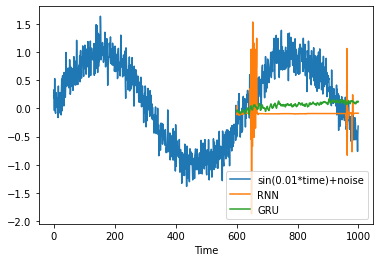

In [347]:
T = 1000
time = torch.arange(0.0, T)
X = torch.sin(0.01 * time) + 0.2 * torch.randn(T)
plt.plot(time.numpy(), X.numpy(), label="sin(0.01*time)+noise");
plt.plot(time[600:].numpy(), rnntest.detach().numpy(), label='RNN')
plt.plot(time[600:].numpy(), grutest.detach().numpy(), label='GRU')
plt.legend();
plt.xlabel("Time");
plt.show()